Predicting stock volume with LSTM

In [1]:
import urllib.request
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable

Download Starbucks training data from yahoo stocks

In [2]:
if not os.path.isfile('./datasets/STOCKS/starbucks.csv'):
    os.mkdir('./datasets/STOCKS')
    urllib.request.urlretrieve(
        "https://query1.finance.yahoo.com/v7/finance/download/SBUX?period1=1576063151&period2=1607685551&interval=1d&events=history&includeAdjustedClose=true",
        './datasets/STOCKS/starbucks.csv')

Load and evaluate data

In [3]:
df = pd.read_csv('./datasets/STOCKS/starbucks.csv',
                 index_col='Date', parse_dates=True)

df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,83.460548,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.022011,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,85.465378,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,85.571404,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,84.944901,7296900


<AxesSubplot:title={'center':'StarBucks Stock Volume'}, xlabel='Date'>

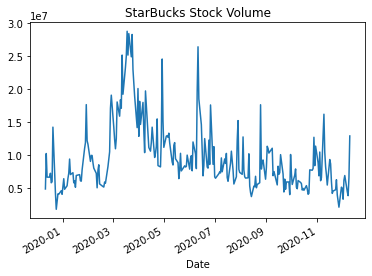

In [4]:
df['Volume'].plot(label='CLOSE', title='StarBucks Stock Volume')

Split data into inputs and labels

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]

Scale data

In [6]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

Train / Test data split

In [7]:
X_train = X_ss[:160, :]
X_val = X_ss[160:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:160, :]
y_val = y_mm[160:200,:]
y_test = y_mm[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Validation Shape", X_val.shape, y_val.shape)
print("Testing Shape", X_test.shape, y_test.shape)


Training Shape (160, 5) (160, 1)
Validation Shape (40, 5) (40, 1)
Testing Shape (53, 5) (53, 1)


Convert data to tensors

In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_val_tensors = Variable(torch.Tensor(X_val))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_val_tensors = Variable(torch.Tensor(y_val))
y_test_tensors = Variable(torch.Tensor(y_test))


Reshape data

In [9]:
X_train_tensors_final = torch.reshape(
    X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_val_tensors_final = torch.reshape(
    X_val_tensors,   (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

X_test_tensors_final = torch.reshape(
    X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Validation Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([160, 1, 5]) torch.Size([160, 1])
Validation Shape torch.Size([160, 1, 5]) torch.Size([160, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


Define model

In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0),
                       self.hidden_size))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0),
                       self.hidden_size))  # internal state
        # Propagate input through LSTM
        # lstm with input, hidden, and internal state
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        # reshaping the data for Dense layer next
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        out = self.fc(out)  # Final Output
        return out

Hyperparameters

In [11]:
num_epochs = 1500  # 1000 epochs
learning_rate = 0.001  # 0.001 lr

input_size = 5  # number of features
hidden_size = 2  # number of features in hidden state
num_layers = 1  # number of stacked lstm layers

num_classes = 1  # number of output classes

In [12]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers,
              X_train_tensors_final.shape[1])  # our lstm class
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

Create a baseline tensor where predicted data equals data from previous day

In [13]:
y_baseline_tensor = y_train_tensors.clone()
y_baseline_tensor[1:] = y_train_tensors.clone()[:-1]

Train model

In [14]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final)  # forward pass
  optimizer.zero_grad()  # caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
  
  loss.backward()  # calculates the loss of the loss function

  optimizer.step()  # improve from loss, i.e backprop


  if epoch % 100 == 0:
    print(f"Epoch: {epoch:#d}, loss: {loss.item():#1.5f}")

    with torch.no_grad():
      val_output = lstm1.forward(X_val_tensors_final)
      val_loss = criterion(val_output, y_val_tensors)
      print(f"Epoch: {epoch}, val loss: {val_loss.item():#1.5f}")

    baseline_loss = criterion(y_baseline_tensor, y_train_tensors)
    print(f"Epoch: {epoch:#d}, baseline loss: {baseline_loss.item():#1.5f}")


Epoch: 0, loss: 0.19012
Epoch: 0, val loss: 0.04401
Epoch: 0, baseline loss: 0.01900
Epoch: 100, loss: 0.02582
Epoch: 100, val loss: 0.01574
Epoch: 100, baseline loss: 0.01900
Epoch: 200, loss: 0.01835
Epoch: 200, val loss: 0.01283
Epoch: 200, baseline loss: 0.01900
Epoch: 300, loss: 0.01761
Epoch: 300, val loss: 0.01323
Epoch: 300, baseline loss: 0.01900
Epoch: 400, loss: 0.01664
Epoch: 400, val loss: 0.01377
Epoch: 400, baseline loss: 0.01900
Epoch: 500, loss: 0.01523
Epoch: 500, val loss: 0.01313
Epoch: 500, baseline loss: 0.01900
Epoch: 600, loss: 0.01395
Epoch: 600, val loss: 0.01298
Epoch: 600, baseline loss: 0.01900
Epoch: 700, loss: 0.01296
Epoch: 700, val loss: 0.01263
Epoch: 700, baseline loss: 0.01900
Epoch: 800, loss: 0.01240
Epoch: 800, val loss: 0.01166
Epoch: 800, baseline loss: 0.01900
Epoch: 900, loss: 0.01203
Epoch: 900, val loss: 0.01095
Epoch: 900, baseline loss: 0.01900
Epoch: 1000, loss: 0.01180
Epoch: 1000, val loss: 0.01042
Epoch: 1000, baseline loss: 0.01900
Ep

Checking on predictions on test data

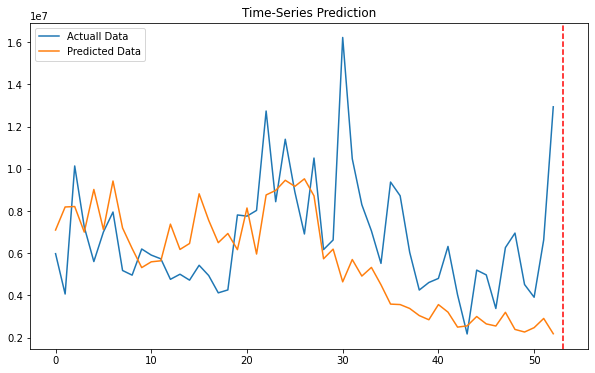

In [15]:
train_predict = lstm1(X_test_tensors_final)  # forward pass
data_predict = train_predict.data.numpy()  # numpy conversion
dataY_plot = y_test_tensors.data.numpy()

data_predict = mm.inverse_transform(data_predict)  # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(10, 6))  # plotting
plt.axvline(x=53, c='r', linestyle='--')  # size of the training set

plt.plot(dataY_plot, label='Actuall Data')  # actual plot
plt.plot(data_predict, label='Predicted Data')  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()
